## Pandas处理分析网站原始访问日志

目标：真实项目的实战，探索Pandas的数据处理与分析

处理分析步骤：  
1、读取多个文件到一个df  
2、整理提取所需要的列  
3、实现小时粒度、天粒度的PV/UV统计  

### 1、读取多个文件数据到df

数据来源：我自己的wordpress博客http://www.crazyant.net/ 的访问日志  
统计目标：该网站的按小时、按天的PV/UV数据

In [22]:
import pandas as pd
import numpy as np
%matplotlib inline

In [23]:
data_dir = "./datas/crazyant/blog_access_log"

df_list = []

import os
for fname in os.listdir(f"{data_dir}"):
    df_list.append(pd.read_csv(f"{data_dir}/{fname}", sep=" ", header=None, error_bad_lines=False))

df = pd.concat(df_list)

b'Skipping line 2245: expected 10 fields, saw 16\nSkipping line 2889: expected 10 fields, saw 14\nSkipping line 2890: expected 10 fields, saw 14\nSkipping line 2891: expected 10 fields, saw 13\nSkipping line 2892: expected 10 fields, saw 13\nSkipping line 2900: expected 10 fields, saw 11\nSkipping line 2902: expected 10 fields, saw 11\nSkipping line 3790: expected 10 fields, saw 14\nSkipping line 3791: expected 10 fields, saw 14\nSkipping line 3792: expected 10 fields, saw 13\nSkipping line 3793: expected 10 fields, saw 13\nSkipping line 3833: expected 10 fields, saw 11\nSkipping line 3835: expected 10 fields, saw 11\nSkipping line 9936: expected 10 fields, saw 16\n'
b'Skipping line 11748: expected 10 fields, saw 11\nSkipping line 11750: expected 10 fields, saw 11\n'


In [24]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,106.11.153.226,-,-,[02/Dec/2019:22:40:18,+0800],GET /740.html?replytocom=1194 HTTP/1.0,200,13446,-,YisouSpider
1,42.156.254.60,-,-,[02/Dec/2019:22:40:23,+0800],POST /wp-json/wordpress-popular-posts/v1/popul...,201,55,http://www.crazyant.net/740.html?replytocom=1194,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,106.11.159.254,-,-,[02/Dec/2019:22:40:27,+0800],GET /576.html HTTP/1.0,200,13461,-,YisouSpider
3,106.11.157.254,-,-,[02/Dec/2019:22:40:28,+0800],GET /?lwfcdw=t9n2d3&oqzohc=m5e7j1&oubyvq=iab6a...,200,10485,-,YisouSpider
4,42.156.137.109,-,-,[02/Dec/2019:22:40:30,+0800],POST /wp-json/wordpress-popular-posts/v1/popul...,201,55,http://www.crazyant.net/576.html,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...


In [25]:
df = df[[0, 3, 6, 9]].copy()
df.head()

,0,3,6,9
0,106.11.153.226,[02/Dec/2019:22:40:18,200,YisouSpider
1,42.156.254.60,[02/Dec/2019:22:40:23,201,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,106.11.159.254,[02/Dec/2019:22:40:27,200,YisouSpider
3,106.11.157.254,[02/Dec/2019:22:40:28,200,YisouSpider
4,42.156.137.109,[02/Dec/2019:22:40:30,201,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...


In [26]:
df.columns = ["ip", "stime", "status", "client"]

In [27]:
df.head()

,ip,stime,status,client
0,106.11.153.226,[02/Dec/2019:22:40:18,200,YisouSpider
1,42.156.254.60,[02/Dec/2019:22:40:23,201,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
2,106.11.159.254,[02/Dec/2019:22:40:27,200,YisouSpider
3,106.11.157.254,[02/Dec/2019:22:40:28,200,YisouSpider
4,42.156.137.109,[02/Dec/2019:22:40:30,201,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...


In [28]:
df.dtypes

ip        object
stime     object
status     int64
client    object
dtype: object

In [29]:
df = df[(df["status"]==200) & (~ df["client"].str.lower().str.contains("spider"))].copy()

In [30]:
df

,ip,stime,status,client
5,113.246.154.26,[02/Dec/2019:22:40:46,200,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1...
6,46.229.168.163,[02/Dec/2019:22:41:52,200,Mozilla/5.0 (compatible; SemrushBot/6~bl; +htt...
8,46.229.168.133,[02/Dec/2019:22:41:55,200,Mozilla/5.0 (compatible; SemrushBot/6~bl; +htt...
10,146.66.92.61,[02/Dec/2019:22:42:48,200,WordPress/5.3; http://www.crazyant.net
12,137.74.38.160,[02/Dec/2019:22:42:49,200,Tiny Tiny RSS/19.8 (f609065) (http://tt-rss.org/)
...,...,...,...,...
6765,141.8.132.24,[07/Dec/2019:21:30:17,200,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
6766,141.8.132.24,[07/Dec/2019:21:30:19,200,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
6768,141.8.132.24,[07/Dec/2019:21:30:21,200,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
6771,141.8.132.24,[07/Dec/2019:21:30:56,200,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...


In [31]:
df["stime"] = pd.to_datetime(df["stime"].str[1:], format="%d/%b/%Y:%H:%M:%S")

In [32]:
df

,ip,stime,status,client
5,113.246.154.26,2019-12-02 22:40:46,200,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1...
6,46.229.168.163,2019-12-02 22:41:52,200,Mozilla/5.0 (compatible; SemrushBot/6~bl; +htt...
8,46.229.168.133,2019-12-02 22:41:55,200,Mozilla/5.0 (compatible; SemrushBot/6~bl; +htt...
10,146.66.92.61,2019-12-02 22:42:48,200,WordPress/5.3; http://www.crazyant.net
12,137.74.38.160,2019-12-02 22:42:49,200,Tiny Tiny RSS/19.8 (f609065) (http://tt-rss.org/)
...,...,...,...,...
6765,141.8.132.24,2019-12-07 21:30:17,200,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
6766,141.8.132.24,2019-12-07 21:30:19,200,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
6768,141.8.132.24,2019-12-07 21:30:21,200,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
6771,141.8.132.24,2019-12-07 21:30:56,200,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...


### 2、实现按小时粒度的流量统计

In [33]:
df.set_index("stime", inplace=True)
df.sort_index(inplace=True)
df.head()

,ip,status,client
stime,,,
2019-12-02 22:40:46,113.246.154.26,200,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1...
2019-12-02 22:41:52,46.229.168.163,200,Mozilla/5.0 (compatible; SemrushBot/6~bl; +htt...
2019-12-02 22:41:55,46.229.168.133,200,Mozilla/5.0 (compatible; SemrushBot/6~bl; +htt...
2019-12-02 22:42:48,146.66.92.61,200,WordPress/5.3; http://www.crazyant.net
2019-12-02 22:42:49,137.74.38.160,200,Tiny Tiny RSS/19.8 (f609065) (http://tt-rss.org/)


In [34]:
df.index

DatetimeIndex(['2019-12-02 22:40:46', '2019-12-02 22:41:52',
               '2019-12-02 22:41:55', '2019-12-02 22:42:48',
               '2019-12-02 22:42:49', '2019-12-02 22:42:49',
               '2019-12-02 22:42:54', '2019-12-02 22:43:07',
               '2019-12-02 22:43:28', '2019-12-02 22:43:48',
               ...
               '2019-12-07 21:27:57', '2019-12-07 21:28:08',
               '2019-12-07 21:29:12', '2019-12-07 21:30:12',
               '2019-12-07 21:30:15', '2019-12-07 21:30:17',
               '2019-12-07 21:30:19', '2019-12-07 21:30:21',
               '2019-12-07 21:30:56', '2019-12-07 21:30:58'],
              dtype='datetime64[ns]', name='stime', length=39522, freq=None)

In [44]:
df_result = df.resample("6H")["ip"].agg(pv=np.size, uv=pd.Series.nunique)
df_result

,pv,uv
stime,,
2019-12-02 18:00:00,234,56
2019-12-03 00:00:00,831,158
2019-12-03 06:00:00,1935,264
2019-12-03 12:00:00,2485,290
2019-12-03 18:00:00,2923,286
2019-12-04 00:00:00,1234,189
2019-12-04 06:00:00,3556,305
2019-12-04 12:00:00,2517,288
2019-12-04 18:00:00,3261,254


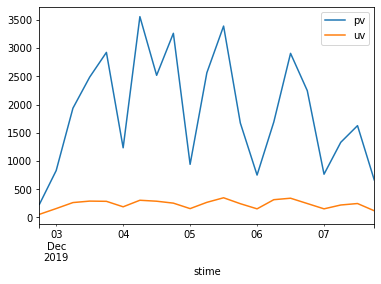

In [43]:
df_result.plot()

In [37]:
df_result = df.resample("D")["ip"].agg(pv=np.size, uv=pd.Series.nunique)
df_result.head()

,pv,uv
stime,,
2019-12-02,234,56
2019-12-03,8174,842
2019-12-04,10568,844
2019-12-05,8565,850
2019-12-06,7593,874


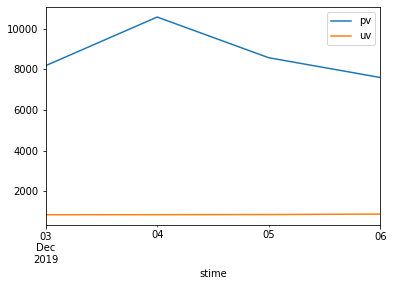

In [39]:
df_result.iloc[1:-1, :].plot()

In [40]:
df_result.iloc[1:-1, :]

,pv,uv
stime,,
2019-12-03,8174,842
2019-12-04,10568,844
2019-12-05,8565,850
2019-12-06,7593,874
